In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Covid_19_tweets_train.csv to Covid_19_tweets_train (1).csv


In [ ]:
! pip uninstall nltk
! pip install -U nltk
import nltk
nltk.download('all')

In [ ]:
%matplotlib inline
import io
import re
import nltk
import string
import requests
import numpy as np
import pandas as pd
from collections import Counter
from scipy import sparse as sp_sparse

# NLTK
from nltk.lm import MLE
from nltk.util import ngrams
from nltk.corpus import wordnet
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.metrics import BigramAssocMeasures
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.lm.preprocessing import padded_everygram_pipeline

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier

# Keras
from keras.layers import Dense
from keras.datasets import imdb
from keras.layers import Flatten
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
def filterTweet(tweet):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Removing links
    filteredTweet = re.sub(r"http\S+", '', tweet)

    # Making the letters lowercase
    filteredTweet = filteredTweet.lower()

    # Removing punctuation
    # The list of punctuation is taken from string.punctuation but removed the hashtags and @
    # Removed the # to use them later, and removed to the @ to remove the persons name since we don't need it
    filteredTweet = filteredTweet.translate(str.maketrans('', '', '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'))

    # Removing persons names and persons tags
    filteredTweet = re.sub(r"@(\w+)", '', filteredTweet)

    # Removing stopwords
    tweetTokenizer = TweetTokenizer()
    tokens = tweetTokenizer.tokenize(filteredTweet)
    result = [i for i in tokens if not i in stop_words]
    filteredTweet = " ".join(result)

    # Removing extra whitespaces
    filteredTweet = filteredTweet.strip()

    # Lemmatization
    filteredTweetWords = filteredTweet.split()
    lemmatizerTweetWords = [lemmatizer.lemmatize(word) for word in filteredTweetWords]
    lemmatizedTweet = ' '.join(lemmatizerTweetWords)

    return lemmatizedTweet

# Filter tweet with removing hashtags
def filterTweetHashtags(tweet):
    filteredTweet = filterTweet(tweet)
    filteredTweet = re.sub(r"#(\w+)", '', filteredTweet)
    return filteredTweet

# Remove hashtags from tweet
def removeHashtags(tweet):
    # Removing persons names and persons tags
    filteredTweet = re.sub(r"#(\w+)", '', tweet)
    return filteredTweet

# Cleaning result function for lists
def cleaning_result(tweets):
    return [filterTweet(tweet) for tweet in tweets]

In [ ]:
# Getting the tweets and filtering them
# url = 'https://gitlab.com/mhd-yasser-haddad/nlp/-/blob/master/Covid_19_tweets_train.csv'
# s = requests.get(url).content
# c = pd.read_csv(io.StringIO(s.decode('latin1')), error_bad_lines=False)
# list(c['OriginalTweet'])
# tweetsContent = pd.read_csv(url, encoding='latin1',header='Content-Type: text/csv')
tweetsContent = pd.read_csv(io.BytesIO(uploaded['Covid_19_tweets_train.csv']), encoding='latin1')
# tweetsContent = pd.read_csv('Covid_19_tweets_train.csv', encoding='latin1')

In [ ]:
originalTweets = list(tweetsContent['OriginalTweet'])
originalSentiment = list(tweetsContent['Sentiment'])
filteredTweets = [filterTweet(tweet) for tweet in originalTweets if filterTweet(tweet) != '']

# Getting the locations
locationsNotFiltered = list(tweetsContent['Location'])
locations = [location for location in locationsNotFiltered if location != '' and location is not None]

Most common Bigrams:
[(('covid', '19'), 10356), (('grocery', 'store'), 5021), (('#coronavirus', '#covid19'), 1891), (('#covid19', '#coronavirus'), 1688), (('hand', 'sanitizer'), 1491), (('online', 'shopping'), 1303), (('toilet', 'paper'), 1231), (('â', '\x93'), 1118), (('panic', 'buying'), 1053), (('iâ', '\x92'), 1016)]

Most common Trigrams:
[(('covid', '19', 'pandemic'), 888), (('due', 'covid', '19'), 564), (('grocery', 'store', 'worker'), 483), (('covid', '19', 'outbreak'), 380), (('covid', '19', 'crisis'), 378), (('amid', 'covid', '19'), 323), (('go', 'grocery', 'store'), 298), (('grocery', 'store', 'employee'), 273), (('spread', 'covid', '19'), 246), (('going', 'grocery', 'store'), 205)]

Most common Bigrams Collocations:
[('covid', '19'), ('grocery', 'store'), ('toilet', 'paper'), ('hand', 'sanitizer'), ('â', '\x93'), ('panic', 'buying'), ('online', 'shopping'), ('iâ', '\x92'), ('social', 'distancing'), ('itâ', '\x92'), ('donâ', '\x92'), ('oil', 'price'), ('#coronavirus', '#covid

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


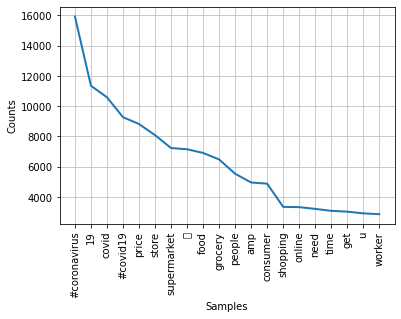


Least Common Words:
[('studyâ', 1), ('authenticate', 1), ('sneakerheads', 1), ('agtech', 1), ('traction', 1), ('rampups', 1), ('sunset', 1), ('squeo', 1), ('carifika', 1), ('gampg', 1), ('reservoir', 1), ('jaffri', 1), ('171525ounce', 1), ('172220', 1), ('rs46215', 1), ('rejecting', 1), ('martinsville', 1), ('newused', 1), ('rift', 1), ('whethe', 1)]

Typo Words:
['coronavirus', 'amid', 'covid', 'dont', 'everyone', 'im', 'litteraly', 'dont', 'regionâ', '\x92']

Most used Hashtags:
[('coronavirus', 15935), ('covid19', 9276), ('covid2019', 1673), ('toiletpaper', 1613), ('socialdistancing', 944), ('coronacrisis', 767), ('pandemic', 477), ('stayhome', 456), ('coronavirusoutbreak', 440), ('coronaviruspandemic', 440)]

Location:
[(nan, 8590), ('London', 540), ('United States', 528), ('London, England', 520), ('New York, NY', 395), ('Washington, DC', 373), ('United Kingdom', 337), ('Los Angeles, CA', 281), ('India', 268), ('UK', 232), ('Australia', 225), ('USA', 223), ('Canada', 191), ('Engl

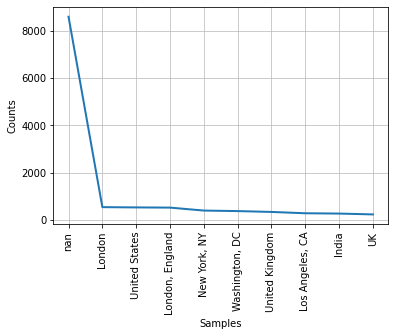

In [ ]:
# Joining all tweets to analyize them
allTweets = ' '.join(str(s) for s in filteredTweets)
allTweetsWords = allTweets.split()
wordsNoHashtags = [w for w in allTweetsWords if not re.match(r"#(\w+)",w)]
words = [w for w in allTweetsWords]

# Tokenizing the tweets
tweetTokenizer = TweetTokenizer()
tokens = tweetTokenizer.tokenize(allTweets)


# Bigrams
bigrams = nltk.bigrams(tokens)
frequentBigrams = nltk.FreqDist(bigrams)

print('Most common Bigrams:')
print(frequentBigrams.most_common()[:10])
print('')


# Trigrams
trigrams = nltk.trigrams(tokens)
frequentTrigrams = nltk.FreqDist(trigrams)

print('Most common Trigrams:')
print(frequentTrigrams.most_common()[:10])
print('')


# Bigram collocations
bigramMeasures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(words)
finder.apply_freq_filter(1)
bigramCollections = finder.nbest(bigramMeasures.likelihood_ratio, 15)

print('Most common Bigrams Collocations:')
print(bigramCollections[:15])
print('')


# Most and Least common words
commonWords = nltk.FreqDist(tokens)
print('Most Common Words:')
print(commonWords.most_common()[:20])
print('')

commonWordsPlot = nltk.FreqDist(dict(commonWords.most_common()[:20]))
print('Most Common Words Plot:')
commonWordsPlot.plot()
print('')


leastCommonWords = nltk.FreqDist(wordsNoHashtags)
print('Least Common Words:')
print(leastCommonWords.most_common()[-20:])
print('')

# Typos in tweets
typoWords = [w for w in wordsNoHashtags if not wordnet.synsets(w) ]
print('Typo Words:')
print(typoWords[:10])
print('')

# Finding the most used hashtags
hashtags = re.findall(r"#(\w+)", allTweets)
print('Most used Hashtags:')
print(Counter(hashtags).most_common(10))
print('')

# The most tweeted locations and plotting them
locationFreq = nltk.FreqDist(locations)
locationFreqPlot = nltk.FreqDist(dict(locationFreq.most_common(10)))
print('Location:')
print(locationFreq.most_common(20))
print('')
print('Locations Plot:')
locationFreqPlot.plot()

In [ ]:
# Language Model
detokenize = TreebankWordDetokenizer().detokenize

def generateSent(model, num_words, random_seed=42):
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)


tweetsCorpus = list(tweetsContent['OriginalTweet'].apply(word_tokenize))

# Preprocess the tokenized text for 3-grams language modelling
n = 3
trainData, paddedSents = padded_everygram_pipeline(n, tweetsCorpus)

tweetsModel = MLE(n) # Lets train a 3-grams model, previously we set n=3
tweetsModel.fit(trainData, paddedSents)

In [ ]:
print(generateSent(tweetsModel, num_words=20, random_seed=7))
print(generateSent(tweetsModel, num_words=10, random_seed=0))
print(generateSent(tweetsModel, num_words=50, random_seed=10))
print(generateSent(tweetsModel, num_words=100, random_seed=1))

FridayThoughts #coronavirus #coronavirusmemes #BreakingNews #Breaking - Americans are forced to close all retail works who are
spicejet .. I don't have to get into the
farmersmarket is not an opportunity to raise drug prices NO election security needs to stick to instructions . We don't panic, stay strong to fight #COVID #smallbusiness #online shopping affected your #FinancialHealth2020? Visit https: //t.co/PPJejQnm0u
800 more dead in Italy Deaths include a 48 hour shift and the #coronavirus bail-out cash from those displaced by violence living in Germany What is humanity if not ALL) your #coffee #stockup #skinnywine #skinnybooze https: //t.co/KTGTl4om3f


In [ ]:
# Get test and train data
def getTrainTest(tweets):
  training_set_size = int(len(tweets)*0.70)
  X = [tweet[0] for tweet in tweets]
  y = [tweet[1] for tweet in tweets]

  X_train = X[:training_set_size]
  y_train = y[:training_set_size]

  X_test = X[training_set_size:]
  y_test = y[training_set_size:]

  return X_train, y_train, X_test, y_test

# Bag of words
def bagOfWords(text, words_to_index, dict_size):
    result_vector = np.zeros(dict_size)
    tokens = text.split(' ')
    for token in tokens:
         if token in words_to_index:
            index = words_to_index[token]
            result_vector[index]=1
    return result_vector

def executeBagOfWords(X_train, X_test):
  all_words = ' '.join(X_train)
  tokenizer = nltk.tokenize.WhitespaceTokenizer()
  tokens = tokenizer.tokenize(all_words)
  all_words_freq = nltk.FreqDist(tokens)

  DICT_SIZE = 5000
  INDEX_TO_WORDS = {i:word[0] for i,word in enumerate(all_words_freq.most_common(DICT_SIZE))}
  WORDS_TO_INDEX = {word:i for i,word in INDEX_TO_WORDS.items()}
  ALL_WORDS= WORDS_TO_INDEX.keys()

  X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(bagOfWords(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
  X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(bagOfWords(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])

  return X_train_mybag, X_test_mybag

# TF-IDF
def tfidf(X_train, X_test):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X_train) #calcualate the values
    X_train = tfidf_vectorizer.transform(X_train) #make the vectors
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_test, tfidf_vectorizer.vocabulary_

In [ ]:
# Classifier
def train_classifier(X_train, y_train):
    classifier = RidgeClassifier()
    classifier.fit(X_train, y_train)
    return classifier

def useClassifier(X_train, y_train, X_test, y_test):
  classifier = train_classifier(X_train, y_train)
  y_test_predicted_labels = classifier.predict(X_test)
  y_test_predicted_scores = classifier.decision_function(X_test)
  print('Accuracy: '+ str(accuracy_score(y_test, y_test_predicted_labels)))

In [ ]:
def testing_result(filename):
  tweetsContent = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')
  # tweetsContent = pd.read_csv(filename, encoding='latin1')
  originalTweets = list(tweetsContent['OriginalTweet'])
  originalSentiment = list(tweetsContent['Sentiment'])

  # tweets with Sentiment
  tweetsWithSentiment = [(originalTweets[i], originalSentiment[i]) for i in range(0, len(originalTweets))]
  tweetsWithSentimentFiltered = [(filterTweet(tweet[0]), tweet[1]) for tweet in tweetsWithSentiment if filterTweet(tweet[0]) != '']
  tweetsWithSentimentFilteredNoHashtags = [(filterTweetHashtags(tweet[0]), tweet[1]) for tweet in tweetsWithSentiment if filterTweetHashtags(tweet[0]) != '']

  # tweets with two Sentiment (positive - negative)
  # tweetsWith2Sentiment = [(originalTweets[i], originalSentiment[i]) for i in range(0, len(originalTweets))]
  # tweetsWith2SentimentFiltered = [(filterTweet(tweet[0]), 'Positive' if tweet[1] == 'Positive' or tweet[1] == 'Extremely Positive' else 'Negative') for tweet in tweetsWith2Sentiment if filterTweet(tweet[0]) != '' and tweet[1] != 'Neutral']
  # tweetsWith2SentimentFilteredNoHashtags = [(filterTweetHashtags(tweet[0]), 'Positive' if tweet[1] == 'Positive' or tweet[1] == 'Extremely Positive' else 'Negative') for tweet in tweetsWith2Sentiment if filterTweetHashtags(tweet[0]) != '']

  # Classify
  X_train, y_train, X_test, y_test = getTrainTest(tweetsWithSentimentFilteredNoHashtags)
  X_train_mybag, X_test_mybag = executeBagOfWords(X_train, X_test)
  X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf(X_train, X_test)
  useClassifier(X_train_mybag, y_train, X_test_mybag, y_test)
  useClassifier(X_train_tfidf, y_train, X_test_tfidf, y_test)

In [ ]:
testing_result('Covid_19_tweets_train.csv')

Accuracy: 0.5149108589951378
Accuracy: 0.523419773095624


In [ ]:
print(X_train_tfidf)

In [ ]:
 from prettytable import PrettyTable
 resultsTable = PrettyTable(["model/ test", "binary with hashtags", "binry without hashtag", "multi-class without hashtags","multi-class with hashtags"])

resultsTable.add_row(["Bag Of Words", "{:.4f}".format(0.8493969899332203), "{:.4f}".format(0.8298217179902755), "{:.4f}".format(0.5149108589951378) , "{:.4f}".format(0.5047402965724009)])
resultsTable.add_row(["TF/IDF", "{:.4f}".format(0.8553772550583076), "{:.4f}".format(0.846839546191248),"{:.4f}".format(0.523419773095624),"{:.4f}".format(0.5138157361640061)])

print(resultsTable)

+--------------+----------------------+-----------------------+------------------------------+---------------------------+
| model/ test  | binary with hashtags | binry without hashtag | multi-class without hashtags | multi-class with hashtags |
+--------------+----------------------+-----------------------+------------------------------+---------------------------+
| Bag Of Words |        0.8494        |         0.8298        |            0.5149            |           0.5047          |
|    TF/IDF    |        0.8554        |         0.8468        |            0.5234            |           0.5138          |
+--------------+----------------------+-----------------------+------------------------------+---------------------------+


In [ ]:
top_words = 7000

sentences = tweetsContent['OriginalTweet'].values
y = tweetsContent['Sentiment'].values
sentencesFiltered = []
yFiltered = []

# Filtering the tweets
# for i in range(0, len(sentences)):
#   filteredTweet = filterTweetHashtags(sentences[i])
#   if filteredTweet != '' and filteredTweet is not None:
#     sentencesFiltered.append(filterTweet)
#     yFiltered.append(y[i])

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

# Coverting to numpy.ndarray
# sentences_train = np.array(sentences_train)
# sentences_test = np.array(sentences_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

# Looking at the nature of training data
print(X_train[0])
print(y_train[0])
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

X_train = X_train.todense()

  (0, 6505)	1
  (0, 14813)	1
  (0, 17079)	1
  (0, 25215)	1
  (0, 29508)	1
  (0, 41801)	1
  (0, 45480)	1
  (0, 47977)	1
Negative
Shape of training data: 
(30867, 65786)
(30867,)
Shape of test data: 
(10290, 65786)
(10290,)


In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.6129251700680272


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
maxlen = 100
X_train = sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)
# Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model
# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           224000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1255      
Total params: 628,609
Trainable params: 628,609
Non-trainable params: 0
________________________________________________

In [ ]:
# Fitting the data onto model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
def print_words_for_tag(classifier, index_to_words):
    top_positive_words = [index_to_words[index] for index in classifier.coef_.argsort().tolist()[0][-5:]]  # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in classifier.coef_.argsort().tolist()[0][:5]] # bottom-5 words  sorted by the coefficients.
    print('Top Possitive Words:\t{}'.format(', '.join(top_positive_words)))
    print('Top Negative Words:\t{}\n'.format(', '.join(top_negative_words)))

print('______________________________\nClassifier: \t {} '.format('Bag of words'))
print_words_for_tag(classifier_mybag, INDEX_TO_WORDS)

print('______________________________\nClassifier: \t {} '.format('IF-IDF',))
print_words_for_tag(classifier_tfidf, {i:word for word,i in tfidf_vocab.items()})

______________________________
Classifier: 	 Bag of words 
Top Possitive Words:	curious, luckily, thankfully, hilarious, confidence
Top Negative Words:	bullshit, unfair, freak, shitty, failing

______________________________
Classifier: 	 IF-IDF 
Top Possitive Words:	help, hand, free, positive, like
Top Negative Words:	crisis, panic, poor, kill, bullshit

